In [1]:
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import parallel_backend
import pandas as pd
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    GridSearchCV,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.linear_model import (
    LassoCV, 
    LinearRegression
) 
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor, 
    ExtraTreesRegressor, 
    StackingRegressor,
    VotingRegressor
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    RobustScaler
)

# from catboost import CatBoostRegressor
# import lightgbm as lgb

In [2]:
data = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Project\used\train_2015.csv')
data['month'] = pd.to_datetime(data['month'])
data['month'] = pd.Categorical(data['month']).codes ## month-1 = 2015-01-01, month-71 = 2020-12-01
data = data.sort_values(by='month').reset_index(drop=True)
data

,month,floor_area_sqm,remaining_lease,MRT_distance,Mall_distance,Market_distance,Hawker_distance,CBD_distance,flat_type_1 ROOM,flat_type_2 ROOM,...,district_18,district_19,district_20,district_21,district_22,district_23,district_25,district_27,district_28,target
0,0,88.0,84,0.994266,0.808769,0.047046,0.185346,6.376045,0,0,...,0,0,1,0,0,0,0,0,0,259120.206490
1,0,84.0,69,0.200669,0.126336,0.121189,0.056087,2.210677,0,0,...,0,0,0,0,0,0,0,0,0,239675.516224
2,0,74.0,67,0.210231,0.154911,0.228448,0.025700,2.679047,0,0,...,0,0,0,0,0,0,0,0,0,221238.938053
3,0,84.0,70,0.262545,0.202888,0.204460,0.308133,2.594427,0,0,...,0,0,0,0,0,0,0,0,0,243362.831858
4,0,104.0,72,0.248533,0.203753,0.091573,0.012464,3.150545,0,0,...,0,0,0,0,0,0,0,0,0,247050.147493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122846,71,46.0,93,0.049306,0.610338,0.058236,1.216475,15.114255,0,1,...,0,0,0,0,0,0,1,0,0,183924.692252
122847,71,46.0,93,0.049306,0.610338,0.058236,1.216475,15.114255,0,1,...,0,0,0,0,0,0,1,0,0,181752.353367
122848,71,148.0,62,0.364824,0.184935,0.208555,1.903213,10.007279,0,0,...,0,1,0,0,0,0,0,0,0,474293.989862
122849,71,93.0,63,0.404561,0.333974,0.138210,0.237594,2.709955,0,0,...,0,0,0,0,0,0,0,0,0,278783.490224


In [3]:
print("Resale price standard deviation:", np.std(data['target']))

Resale price standard deviation: 111557.94061028656


In [4]:
# plt.figure(figsize=(10,15))
# for i, feature in enumerate(['floor_area_sqm', 'remaining_lease', 'MRT_distance', 'Mall_distance', 'Hawker_distance', 'CBD_distance', 'target']):
#     plt.subplot(4, 2, i+1)
#     sns.scatterplot(x=data['month'], y=data[feature])
# plt.show()

# Data windowing

Important to split by the months, do not want contamination through the months.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [5]:
data = data.set_index('month')
X = data.drop('target', axis=1)
y = np.log1p(data['target'])

X, X_test, y, y_test = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=42)

X_test = X_test.reset_index()
y_test = y_test.reset_index(drop=True)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

X shape: (61425, 40)
X_test shape: (61426, 41)


In [6]:
def model_training(algorithm):
    i = 0
    scores = []
    n_splits = 10
    print('Training start...')

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, val_idx in tscv.split(X, y):
        i += 1   
        X_train = X.iloc[train_idx, :].reset_index()
        X_val = X.iloc[val_idx, :].reset_index()
        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        y_true_test = y_test

        # for feature in ['floor_area_sqm', 'remaining_lease']:
        #     scaler = MinMaxScaler().fit(X_train[[feature]])
        #     X_train[feature] = scaler.transform(X_train[[feature]])
        #     X_val[feature] = scaler.transform(X_val[[feature]])
        #     X_test[feature] = scaler.transform(X_test[[feature]])

        start_time = time.time()

        with parallel_backend('threading'):
            model = algorithm.fit(X_train, y_train)

        end_time = time.time()

        y_pred_train = np.log1p(model.predict(X_train))
        y_pred_val = np.log1p(model.predict(X_val))
        y_pred_test = np.log1p(model.predict(X_test))

        train_rmse = np.exp(mean_squared_error(y_train, y_pred_train, squared=False)).round(4)
        val_rmse = np.exp(mean_squared_error(y_val, y_pred_val, squared=False)).round(4)
        test_rmse = np.exp(mean_squared_error(y_true_test, y_pred_test, squared=False)).round(4)

        time_elapsed = round(end_time-start_time, 3)
        print(f"Fold {i}: Train RMSE = {train_rmse}, Val RMSE = {val_rmse}, Test RMSE = {test_rmse} Time elapsed = {time_elapsed}s")
        scores.append([train_rmse, val_rmse, test_rmse])
        
    scores = pd.DataFrame(scores, columns=['train_rmse', 'val_rmse', 'test_rmse'])

    plt.figure(figsize=(10,5))
    sns.lineplot(x=scores.index, y=scores['train_rmse'], label='train_rmse')
    sns.lineplot(x=scores.index, y=scores['val_rmse'], label='val_rmse')
    sns.lineplot(x=scores.index, y=scores['test_rmse'], label='test_rmse')
    plt.xticks(range(n_splits))
    plt.xlabel('folds'); plt.ylabel('scores')
    plt.show()
    return model

Training start...
Fold 1: Train RMSE = 22682.3775, Val RMSE = 22699.2012, Test RMSE = 23258.8381 Time elapsed = 0.014s
Fold 2: Train RMSE = 22692.3239, Val RMSE = 22732.6648, Test RMSE = 23345.6616 Time elapsed = 0.015s
Fold 3: Train RMSE = 22705.3073, Val RMSE = 23040.6313, Test RMSE = 23342.5507 Time elapsed = 0.019s
Fold 4: Train RMSE = 22785.4286, Val RMSE = 22960.1153, Test RMSE = 23298.8865 Time elapsed = 0.023s
Fold 5: Train RMSE = 22819.9477, Val RMSE = 22942.0168, Test RMSE = 23290.9988 Time elapsed = 0.029s
Fold 6: Train RMSE = 22840.3465, Val RMSE = 23060.6955, Test RMSE = 23296.3625 Time elapsed = 0.035s
Fold 7: Train RMSE = 22871.434, Val RMSE = 23269.9758, Test RMSE = 23295.5483 Time elapsed = 0.065s
Fold 8: Train RMSE = 22919.7188, Val RMSE = 23327.6559, Test RMSE = 23276.0314 Time elapsed = 0.055s
Fold 9: Train RMSE = 22965.3945, Val RMSE = 23475.0509, Test RMSE = 23280.7319 Time elapsed = 0.056s
Fold 10: Train RMSE = 23015.8295, Val RMSE = 23723.3045, Test RMSE = 23282

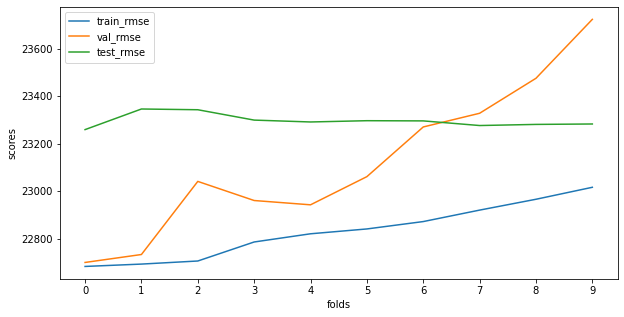

In [7]:
lr = model_training(LinearRegression())

Training start...
Fold 1: Train RMSE = 22679.385, Val RMSE = 22702.0561, Test RMSE = 23253.5518 Time elapsed = 0.051s
Fold 2: Train RMSE = 22689.3135, Val RMSE = 22723.9135, Test RMSE = 23238.8308 Time elapsed = 0.105s
Fold 3: Train RMSE = 22702.2488, Val RMSE = 23036.296, Test RMSE = 23224.5235 Time elapsed = 0.16s
Fold 4: Train RMSE = 22782.2487, Val RMSE = 22942.5267, Test RMSE = 23222.2975 Time elapsed = 0.22s
Fold 5: Train RMSE = 22816.7067, Val RMSE = 22925.938, Test RMSE = 23210.2539 Time elapsed = 0.273s
Fold 6: Train RMSE = 22837.047, Val RMSE = 23039.4253, Test RMSE = 23213.8961 Time elapsed = 0.322s
Fold 7: Train RMSE = 22868.0581, Val RMSE = 23253.4069, Test RMSE = 23232.2801 Time elapsed = 0.389s
Fold 8: Train RMSE = 22916.2452, Val RMSE = 23306.7997, Test RMSE = 23224.5735 Time elapsed = 0.439s
Fold 9: Train RMSE = 22961.8206, Val RMSE = 23447.9042, Test RMSE = 23238.1011 Time elapsed = 0.496s
Fold 10: Train RMSE = 23012.1595, Val RMSE = 23701.0144, Test RMSE = 23248.9283

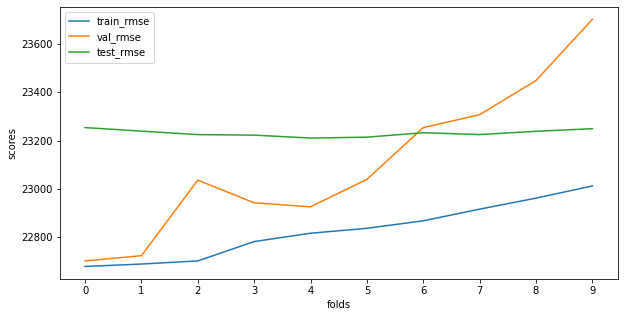

In [8]:
tree = model_training(DecisionTreeRegressor())

Training start...
Fold 1: Train RMSE = 22678.0603, Val RMSE = 22690.8954, Test RMSE = 23231.8207 Time elapsed = 0.577s
Fold 2: Train RMSE = 22688.9021, Val RMSE = 22719.113, Test RMSE = 23233.1192 Time elapsed = 1.13s
Fold 3: Train RMSE = 22701.8238, Val RMSE = 23025.5842, Test RMSE = 23223.2978 Time elapsed = 1.541s
Fold 4: Train RMSE = 22781.7756, Val RMSE = 22937.1764, Test RMSE = 23211.4192 Time elapsed = 2.284s
Fold 5: Train RMSE = 22816.4917, Val RMSE = 22920.0354, Test RMSE = 23212.7414 Time elapsed = 2.819s
Fold 6: Train RMSE = 22836.817, Val RMSE = 23033.5415, Test RMSE = 23207.7357 Time elapsed = 3.253s
Fold 7: Train RMSE = 22867.8241, Val RMSE = 23239.6466, Test RMSE = 23218.0426 Time elapsed = 3.937s
Fold 8: Train RMSE = 22915.8592, Val RMSE = 23292.4937, Test RMSE = 23216.9513 Time elapsed = 4.631s
Fold 9: Train RMSE = 22961.6133, Val RMSE = 23451.3015, Test RMSE = 23239.7969 Time elapsed = 5.013s
Fold 10: Train RMSE = 23012.1109, Val RMSE = 23697.4392, Test RMSE = 23244.3

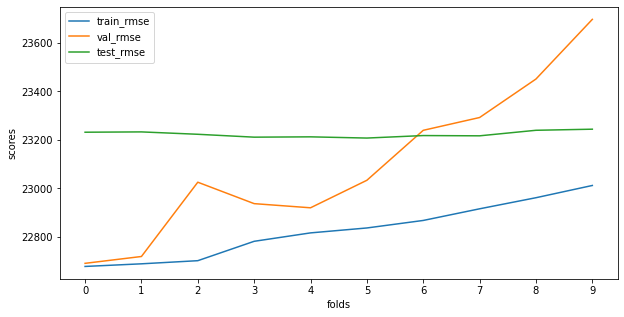

In [9]:
forest = model_training(RandomForestRegressor())

Training start...
Fold 1: Train RMSE = 22679.385, Val RMSE = 22708.1033, Test RMSE = 23237.1494 Time elapsed = 0.358s
Fold 2: Train RMSE = 22689.3135, Val RMSE = 22719.772, Test RMSE = 23218.8375 Time elapsed = 0.721s
Fold 3: Train RMSE = 22702.2488, Val RMSE = 23027.8111, Test RMSE = 23210.8134 Time elapsed = 1.092s
Fold 4: Train RMSE = 22782.2487, Val RMSE = 22943.634, Test RMSE = 23206.9818 Time elapsed = 1.301s
Fold 5: Train RMSE = 22816.7067, Val RMSE = 22926.1616, Test RMSE = 23203.577 Time elapsed = 1.657s
Fold 6: Train RMSE = 22837.047, Val RMSE = 23047.3123, Test RMSE = 23214.0582 Time elapsed = 1.984s
Fold 7: Train RMSE = 22868.0581, Val RMSE = 23248.3297, Test RMSE = 23224.655 Time elapsed = 2.238s
Fold 8: Train RMSE = 22916.2452, Val RMSE = 23308.5279, Test RMSE = 23222.9391 Time elapsed = 2.635s
Fold 9: Train RMSE = 22961.8206, Val RMSE = 23458.4356, Test RMSE = 23238.3362 Time elapsed = 2.985s
Fold 10: Train RMSE = 23012.1595, Val RMSE = 23704.8452, Test RMSE = 23247.3078

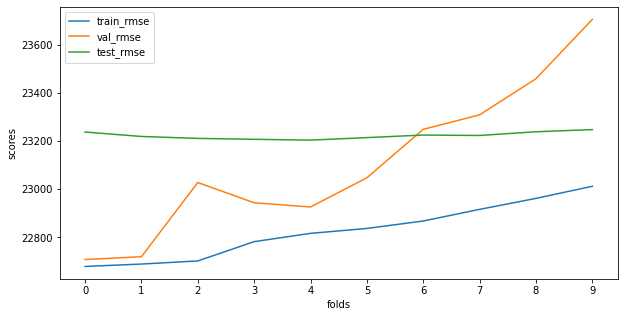

In [10]:
extra_trees = model_training(ExtraTreesRegressor())

Training start...
Fold 1: Train RMSE = 22681.2707, Val RMSE = 22733.2095, Test RMSE = 23241.3299 Time elapsed = 0.93s
Fold 2: Train RMSE = 22691.3398, Val RMSE = 22722.5653, Test RMSE = 23222.3191 Time elapsed = 1.864s
Fold 3: Train RMSE = 22704.3337, Val RMSE = 23026.5227, Test RMSE = 23223.1825 Time elapsed = 2.74s
Fold 4: Train RMSE = 22784.4548, Val RMSE = 22952.2228, Test RMSE = 23220.9959 Time elapsed = 3.587s
Fold 5: Train RMSE = 22818.9875, Val RMSE = 22929.443, Test RMSE = 23224.0178 Time elapsed = 4.464s
Fold 6: Train RMSE = 22839.3767, Val RMSE = 23049.1958, Test RMSE = 23232.3184 Time elapsed = 5.308s
Fold 7: Train RMSE = 22870.4811, Val RMSE = 23260.1183, Test RMSE = 23238.7006 Time elapsed = 6.179s
Fold 8: Train RMSE = 22918.7621, Val RMSE = 23318.6925, Test RMSE = 23242.2574 Time elapsed = 7.036s
Fold 9: Train RMSE = 22964.4341, Val RMSE = 23465.8165, Test RMSE = 23248.8459 Time elapsed = 7.857s
Fold 10: Train RMSE = 23014.8453, Val RMSE = 23709.037, Test RMSE = 23250.52

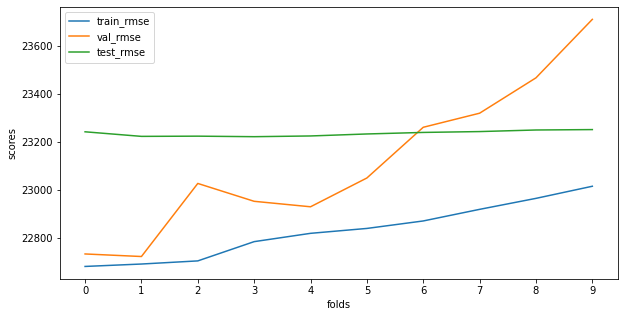

In [11]:
xgb = model_training(GradientBoostingRegressor(
    random_state=42
))

In [12]:
models = [xgb, extra_trees, lr, tree, forest]

results = []
for model in models:
    print(model)
    y_true = y_test
    y_pred = np.log1p(model.predict(X_test))
    rmse = np.exp(mean_squared_error(y_true, y_pred, squared=False)).round(4)
    results.append(rmse)
    print(rmse)

print("Ensemble results:", np.mean(results))

GradientBoostingRegressor(random_state=42)
23250.5275
ExtraTreesRegressor()
23247.3078
LinearRegression()
23282.524
DecisionTreeRegressor()
23248.9283
RandomForestRegressor()
23244.3178
Ensemble results: 23254.72108


In [13]:
# # Save model
# filename = 'xgb_model.sav'
# joblib.dump(xgb, filename)

In [14]:
# # Load model
# path = os.path.join("", filename)
# load_model = joblib.load(path)
# result = load_model.score(X_test, y_test)
# print(result)